### Density Maps for light curves

In [261]:
import pandas as pd
import numpy as np
import zarr
from utils import *
pd.set_option('display.max_columns', 999)

from matplotlib import pyplot as plt
%matplotlib inline

In [262]:
# Run this cell if on SciServer
init()

#### Define Function to Make Density Maps

In [263]:
def dmdt(x, y):
    '''Return dm dt pairs, with dt in the log10 space
    
    Args:
        x(array): An array of time points.
        y(array): The magnitude at each time point in x.
    
    Returns:
        log_dts(array): An array of delta_t between any pair of observations, in
            the log10 scale.
        dms(array): An array of delta_mag corresponding to each delta_t in log_dts.
        dt_amp(float): The largest value in log_dts.
        dm_amp(float): The larges absolute value in dms. 
    '''
    allDiffs = [] # time diff
    allMagDiffs = [] # mag diff
    times = x
    mags = y

    for i in np.arange(1,times.size,1):
        allMagDiffs.append((mags - np.roll(mags, i))[i:])
        allDiffs.append((times-np.roll(times,i))[i:])
        log_dts = np.log10(np.concatenate(allDiffs))
        dms = np.concatenate(allMagDiffs)
    
    dm_amp = np.abs(dms).max() # largest change in mag
    dt_amp = log_dts.max() # largest time interveral
    
    return log_dts, dms, dt_amp, dm_amp


def plotColorDmDt(log_dts, dms, dt_amp, dm_amp, x_bin_size=0.3, y_bin_size=0.002):
    '''Plot the colored DmDt density plot without columne-wise normalization.
    
    Args:
        x(array): An array of time points.
        y(array): The magnitude at each time point in x.
        x_bin_size(float): The size of dt bins, in the log scale.
        y_bin_size(float): The size of dm bins.        
    '''
    
    x_bins = np.int(dt_amp/x_bin_size) # compute number of x bins
    y_bins = np.int(dm_amp/y_bin_size) # compute number of x bins

    # plot
    fig = plt.figure(figsize=(8,6))
    _ = plt.hist2d(log_dts, dms, range=[[0, dt_amp], [-dm_amp, dm_amp]], bins=(x_bins, y_bins))
    plt.colorbar()
    
    return _
    
def plotNormDmDt(denVal, filename=None):
    '''Plot the grayscale DmDt density plot with columne-wise normalization.
    
    Args:
        denVal(array): Density values computed from a colored density map.
        
    '''
    
    fig, ax = plt.subplots(1,1, figsize=(6,6)) # init figure
    
    # perform normalization
    denVal = np.rot90(denVal[0]) # rotate to make x be dt
    y_dim = denVal.shape[0] # number of rows
    x_dim = denVal.shape[1] # number of columns

    # sum over all columns and assign 0 to be 1
    normTotal = np.sum(denVal, axis=0)
    normTotal[normTotal == 0] = 1

    # divide each bin values by normalization and reshape
    normMask = np.repeat(normTotal, y_dim).reshape((x_dim, y_dim)).T
    normd = np.divide(denVal, normMask)

    plt.imshow(np.log(normd), cmap=plt.cm.Greys, extent=[0,3, -1.5, 1.5])
    ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length=5)
    plt.xlabel('$log_{10}(\Delta t\,[days])$', fontsize=15)
    plt.ylabel('$\Delta m \,(arb. unit)$', fontsize=15)
    
    if filename is not None:
        plt.savefig(filename)

### 1. Get Meta info from training data
This section will help find the light curve IDs for objects of different classese (e.g., QSO vs. Star)

In [264]:
## get IDs for variable stars
meta = get_cat('s82Qso')[['train_id', 'class', 'sdss_lcN']]
meta

,train_id,class,sdss_lcN
0,0,s82Qso,54.0
1,1,s82Qso,59.0
2,2,s82Qso,49.0
3,3,s82Qso,50.0
4,4,s82Qso,46.0
...,...,...,...
83876,83876,s82Qso,51.0
83877,83877,s82Qso,93.0
83878,83878,s82Qso,61.0
83879,83879,s82Qso,59.0


### 2. Variable Stars Density Maps
#### 2.1. Single band 
After obtaining the light curves from the database, you can select which bandpass to plot, that is 'psfmag_u', 'psfmag_g', 'psfmag_r', 'psfmag_i', 'psfmag_z'. Normally, g, r and i bands have the largest number of high quality data. 

In [289]:
# retrive LC by ID and select the data from only a single band
band = 'i'
varlc = get_sdss_lc(1000002)
varlc = varlc.dropna(subset=[f'psfmag_{band}'])

/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

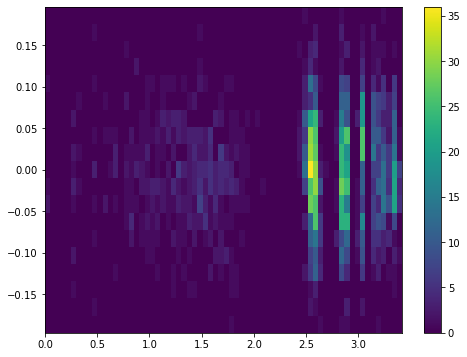

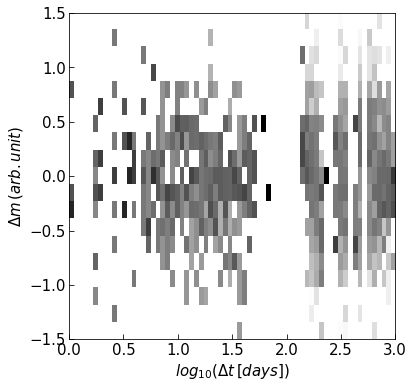

In [290]:
# make colored density map
log_dts, dms, dt_amp, dm_amp = dmdt(varlc[f'mjd_{band}'].values, varlc[f'psfmag_{band}'].values)
denVal = plotColorDmDt(log_dts, dms, dt_amp, dm_amp, x_bin_size=0.05, y_bin_size=0.01)
plotNormDmDt(denVal)

#### 2.2 Non-parametric LC merging?
We could try to combine light curves from all five 'ugriz' bands to make a higher resolution density map. 

In [267]:
varlc = varlc.dropna(subset=['psfmag_g', 'psfmag_u', 'psfmag_r', 'psfmag_i', 'psfmag_z']) # remove nan

In [268]:
g_log_dts, g_dms, g_dt_amp, g_dm_amp = dmdt(varlc.mjd_g.values, varlc.psfmag_g.values)
r_log_dts, r_dms, r_dt_amp, r_dm_amp = dmdt(varlc.mjd_r.values, varlc.psfmag_r.values)
i_log_dts, i_dms, i_dt_amp, i_dm_amp = dmdt(varlc.mjd_i.values, varlc.psfmag_i.values)

In [269]:
log_dts = np.append([g_log_dts, r_log_dts], i_log_dts)
dms = np.append([g_dms, r_dms], i_dms)

## catastrophic error could occur if one of the bands has spurious brighness change
dt_amp = np.median([g_dt_amp, r_dt_amp, i_dt_amp])
dm_amp = np.median([g_dm_amp, r_dm_amp, i_dt_amp])

/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

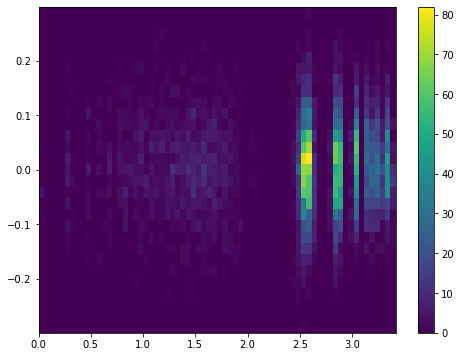

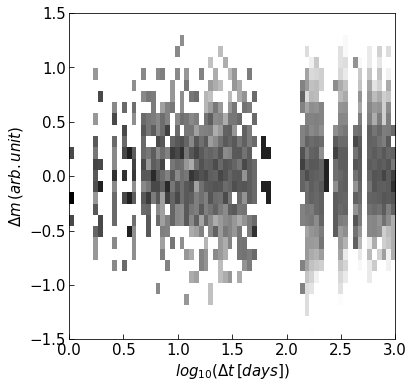

In [270]:
denVal = plotColorDmDt(log_dts, dms, dt_amp, dm_amp, x_bin_size=0.05, y_bin_size=0.01)
plotNormDmDt(denVal)

### 3. Things to explore
- Change the ID and see how the density map changes, this is how we might be able to classify different classes of stars.
- Change the `x_bin_size` and `y_bin_size` argument for the `plotColorDmDt` function. These two parameters could end up being hyperparameters.
- Many more...

In [271]:
help(plot_sdss_lc)

Help on function plot_sdss_lc in module utils:

plot_sdss_lc(train_id, bands=['u', 'g', 'r', 'i', 'z'], clip=True)
    Plot SDSS light curves without merging.
    
    Args:
        train_id (int): Unique ID for an object in training sample.
        bands (list): Optional, a list specifying light curves in which bands to plot.
        clip (bool): Optional, indicates whether to run filter removing outliers, default to True.
    
    Return:
        bands (list): A list specifying the band filters in which to plot the light curves.
        x (list): A list of numpy arrays of mjd for observations in each band.
        y (list): A list of numpy arrays of magnitude in each band (psf mags)
        err (list): A list of numpy arrays of magnitude errors in each band



In [272]:
plot_sdss_lc(1, bands=['u'], clip=True)

(['u'], [array([52075.32, 52197.13, 52557.17, 52929.09, 52934.07, 52936.07,
         53270.13, 53288.11, 53302.11, 53312.06, 53623.16, 53626.14,
         53628.13, 53635.14, 53649.12, 53654.16, 53665.1 , 53668.11,
         53670.11, 53673.08, 53675.08, 53677.1 , 53680.09, 53693.09,
         53995.16, 53997.13, 54005.11, 54007.12, 54009.12, 54011.18,
         54019.13, 54025.18, 54029.11, 54031.1 , 54036.1 , 54039.1 ,
         54041.1 , 54048.09, 54051.09, 54052.1 , 54054.12, 54058.09,
         54063.08, 54366.13, 54381.18, 54382.17, 54383.18, 54386.18,
         54393.17, 54396.1 , 54403.1 , 54406.09, 54412.09, 54416.09,
         54419.09, 54421.09, 54423.09, 54425.09, 54431.1 ])], [array([19.86223 , 20.035145, 20.127964, 20.405367, 20.313492, 20.345375,
         20.640991, 20.801348, 20.686295, 20.618723, 20.928335, 20.926374,
         20.685614, 20.895061, 22.165144, 21.243069, 22.523743, 20.95513 ,
         21.292393, 20.923923, 20.869692, 21.026981, 21.260265, 20.994368,
         20

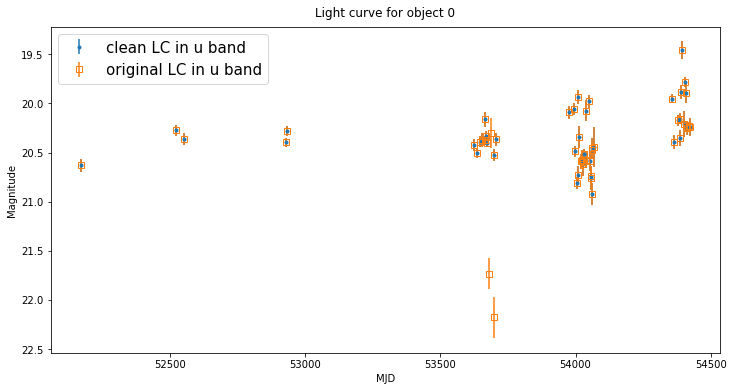

In [273]:
# plot light curves in the u band
fig = plt.figure(figsize=(12,6))
qso_train_id = 0
bands1, x1, y1, err1 = plot_sdss_lc(qso_train_id, bands=['u'])
bands2, x2, y2, err2 = plot_sdss_lc(qso_train_id, bands=['u'], clip=False) # return light curves with bad observations

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='clean LC in {} band'.format(bands1[i]), fmt='.')
    plt.errorbar(x2[i], y2[i], err2[i], label='original LC in {} band'.format(bands2[i]),\
                 fmt='s', markerfacecolor='none')
plt.gca().invert_yaxis()
plt.title('Light curve for object {}'.format(0))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

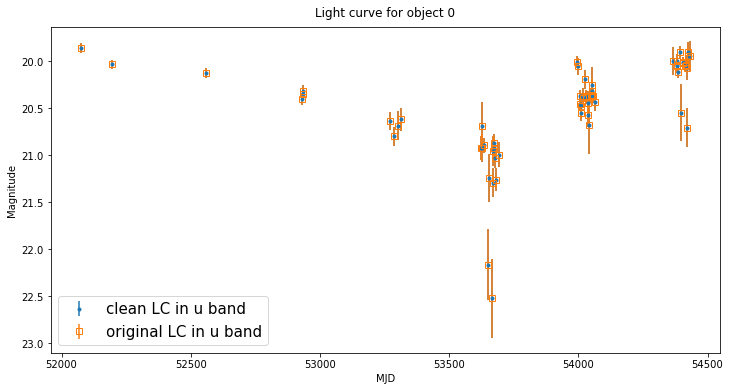

In [274]:
# plot light curves in the u band
fig = plt.figure(figsize=(12,6))
qso_train_id = 1
bands1, x1, y1, err1 = plot_sdss_lc(qso_train_id, bands=['u'])
bands2, x2, y2, err2 = plot_sdss_lc(qso_train_id, bands=['u'], clip=False) # return light curves with bad observations

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='clean LC in {} band'.format(bands1[i]), fmt='.')
    plt.errorbar(x2[i], y2[i], err2[i], label='original LC in {} band'.format(bands2[i]),\
                 fmt='s', markerfacecolor='none')
plt.gca().invert_yaxis()
plt.title('Light curve for object {}'.format(0))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

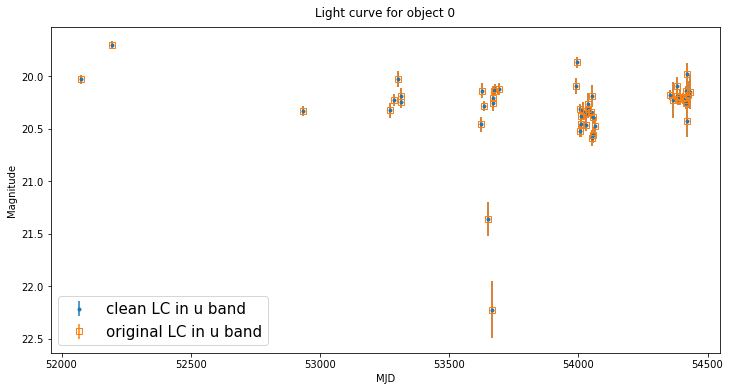

In [275]:
# plot light curves in the u band
fig = plt.figure(figsize=(12,6))
qso_train_id = 2
bands1, x1, y1, err1 = plot_sdss_lc(qso_train_id, bands=['u'])
bands2, x2, y2, err2 = plot_sdss_lc(qso_train_id, bands=['u'], clip=False) # return light curves with bad observations

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='clean LC in {} band'.format(bands1[i]), fmt='.')
    plt.errorbar(x2[i], y2[i], err2[i], label='original LC in {} band'.format(bands2[i]),\
                 fmt='s', markerfacecolor='none')
plt.gca().invert_yaxis()
plt.title('Light curve for object {}'.format(0))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

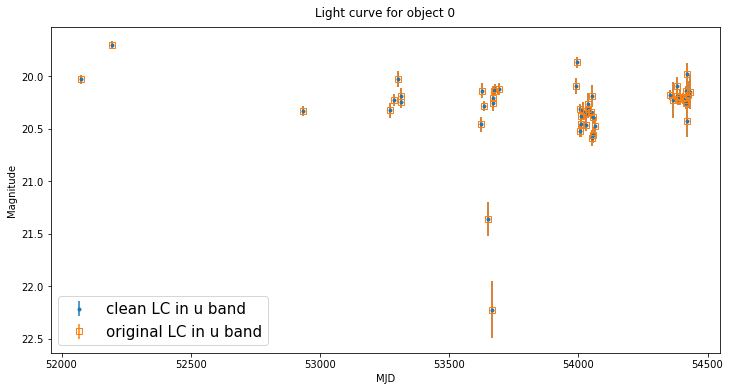

In [276]:
# plot light curves in the u band
fig = plt.figure(figsize=(12,6))
star_train_id = 0
bands1, x1, y1, err1 = plot_sdss_lc(qso_train_id, bands=['u'])
bands2, x2, y2, err2 = plot_sdss_lc(qso_train_id, bands=['u'], clip=False) # return light curves with bad observations

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='clean LC in {} band'.format(bands1[i]), fmt='.')
    plt.errorbar(x2[i], y2[i], err2[i], label='original LC in {} band'.format(bands2[i]),\
                 fmt='s', markerfacecolor='none')
plt.gca().invert_yaxis()
plt.title('Light curve for object {}'.format(0))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

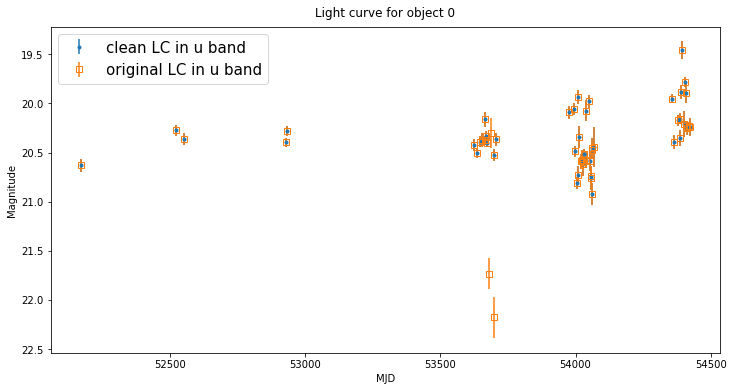

In [277]:
# plot light curves in the u band
fig = plt.figure(figsize=(12,6))
star_train_id = 0
bands1, x1, y1, err1 = plot_sdss_lc(star_train_id, bands=['u'])
bands2, x2, y2, err2 = plot_sdss_lc(star_train_id, bands=['u'], clip=False) # return light curves with bad observations

for i in range(len(bands1)):
    plt.errorbar(x1[i], y1[i], err1[i], label='clean LC in {} band'.format(bands1[i]), fmt='.')
    plt.errorbar(x2[i], y2[i], err2[i], label='original LC in {} band'.format(bands2[i]),\
                 fmt='s', markerfacecolor='none')
plt.gca().invert_yaxis()
plt.title('Light curve for object {}'.format(0))
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend(fontsize=15)

In [296]:
varlc = get_sdss_lc(1000002)
varlc = varlc.dropna(subset=['psFlux_g'])
                             
mjd_g = varlc['mjd_g']
psFlux_g = varlc['psFlux_g']

print("xxxx")
print(mjd_g)
print("xxxx")
print(psFlux_g)
print("xxxx")

KeyError: ['psFlux_g']

In [280]:
a,b,c,d = dmdt(mjd_g, psfmag_g)
print(dmdt(mjd_g, psfmag_g))
print('xxxxxxxxx')
print(a)
print(b)
print(c)
print(d)

(array([2.5477624 , 0.29666519, 1.70739983, ..., 3.41579939, 3.35448876,
       3.41746671]), array([-0.03233337,  0.00525856, -0.06046677, ..., -0.07763672,
       -0.02146149, -0.05379486], dtype=float32), 3.41746671082884, 0.23858643)
xxxxxxxxx
[2.5477624  0.29666519 1.70739983 ... 3.41579939 3.35448876 3.41746671]
[-0.03233337  0.00525856 -0.06046677 ... -0.07763672 -0.02146149
 -0.05379486]
3.41746671082884
0.23858643


/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/idies/miniconda3/envs/lsst_train/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 1.]]),
 array([0.        , 0.31067879, 0.62135758, 0.93203638, 1.24271517,
        1.55339396, 1.86407275, 2.17475154, 2.48543034, 2.79610913,
        3.10678792, 3.41746671]),
 array([-0.23858643, -0.23457657, -0.23056671, -0.22655686, -0.222547  ,
        -0.21853715, -0.21452729, -0.21051743, -0.20650758, -0.20249772,
        -0.19848787, -0.19447801, -0.19046816, -0.1864583 , -0.18244844,
        -0.17843859, -0.17442873, -0.17041888, -0.16640902, -0.16239916,
        -0.15838931, -0.15437945, -0.1503696 , -0.14635974, -0.14234988,
        -0.13834003, -0.13433017, -0.13032032, -0.12631046, -0.1223006 ,
        -0.11829075, -0.11428089, -0.11027104, -0.10626118, -0.10225133,
        -0.09824147, -0.09423161, -0.09022176, -0.0862119 , -0.0822020

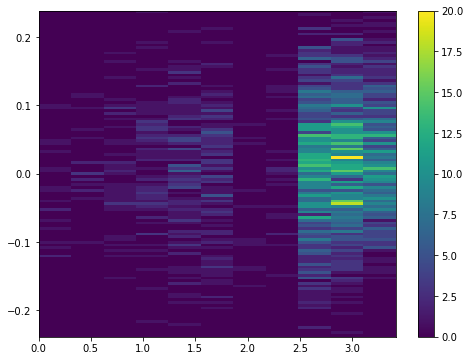

In [282]:
plotColorDmDt(a,b,c,d)

In [284]:
fs_df = pd.read_parquet(os.path.join(data_dir, 'ForcedSourceTable.parquet'))
fs_df.head(3)

,objectId,mjd,psMag,psMagErr,flags,psFlux,psFluxErr,psDiffFlux,psDiffFluxErr,filter
0,1377887,52959.13,23.269028,0.442568,9007199422513169,1584.230835,759.312988,839.39703,1350.93301,0
1,1377887,54379.29,NaN,NaN,9007199397347585,-210.056396,1103.294067,-954.89032,1570.26164,0
2,1377887,53674.19,23.163357,0.562635,9007199397380353,1773.329224,1049.915405,1028.49530,1533.22740,0


In [291]:
# groupby forcedsource table by objectid
fs_gp = fs_df.groupby('objectId')

object_df = pd.read_parquet(os.path.join(data_dir, 'ObjectTable.parquet'))
object_df.head(40)

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,class,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNo